In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics.classification import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm_notebook
import xgboost as xgb

In [2]:
df_train = pd.read_csv('quora_final_features.csv', encoding='latin-1')

y_true = df_train['is_duplicate']
y_true = list(map(int, y_true.values))

df_train = df_train.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)

column_list = list(df_train.columns)

for i in tqdm_notebook(column_list):
    df_train[i] = df_train[i].apply(pd.to_numeric)
    
X_train = df_train.iloc[:, :]
y_train = y_true

In [3]:
df_test = pd.read_csv('quora_test_final_features.csv', encoding='latin-1')

y_test_true = df_test['is_duplicate']
y_test_true = list(map(int, y_test_true.values))

df_test = df_test.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)

column_list = list(df_test.columns)

for i in tqdm_notebook(column_list):
    df_test[i] = df_test[i].apply(pd.to_numeric)
    
X_test = df_test.iloc[:, :]
y_test = y_test_true

In [4]:
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A = ((C.T)/(C.sum(axis=1))).T
    
    B = (C/(C.sum(axis=0)))
    
    plt.figure(figsize=(20,4))
    labels = [1, 2]
    cmap = sns.light_palette('blue')
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion Matrix')
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Precision Matrix')
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Recall Matrix')
    
    plt.show()

Log-loss on test data using Random model: 0.8882837732454583


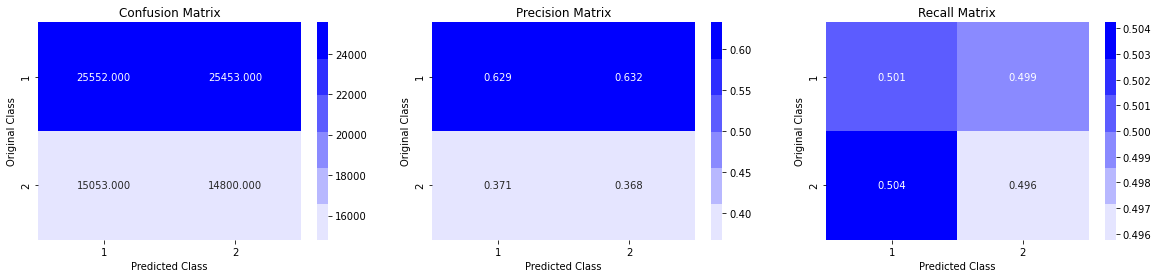

In [5]:
# RANDOM MODEL

test_len = len(y_test)

# creating 2d array as this is 2 class classification, first dimension contains prob of point belonging to class 0
# and second dimension contains prob of point belonging to class 1
predicted_y = np.zeros((test_len, 2))

for i in range(test_len):
    # generate random numbers
    random_prob = np.random.rand(1, 2)
    # normalizing accross rows such that prob1 + prob2 = 1 so that values can be treated as prob values
    predicted_y[i] = ((random_prob/np.sum(random_prob, axis=1)))
    
print('Log-loss on test data using Random model:', log_loss(y_test, predicted_y, eps=1e-15))

# select index of max value in a row to get values in 0 and 1
predicted_y = np.argmax(predicted_y, axis=1)

plot_confusion_matrix(y_test, predicted_y)

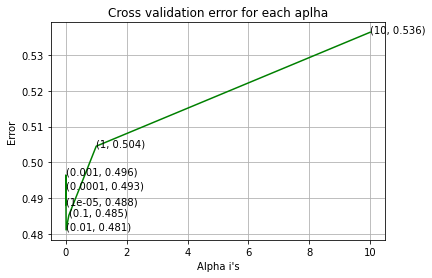

In [6]:
# LOGISTIC REGRESSION WITH HYPERPARAMETER TUNING

alpha = [10 ** x for x in range(-5, 2)]

log_error_array = []

for i in tqdm_notebook(alpha):
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=7)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ' Log-loss: ', log_loss(y_test, predict_y,  labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

for i, text in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i], np.round(text,3)), (alpha[i], log_error_array[i]))

plt.grid()
plt.title('Cross validation error for each aplha')
plt.xlabel("Alpha i's")
plt.ylabel('Error')
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.43327657384628904
For values of best alpha =  0.01 The test log loss is: 0.48110750902781957


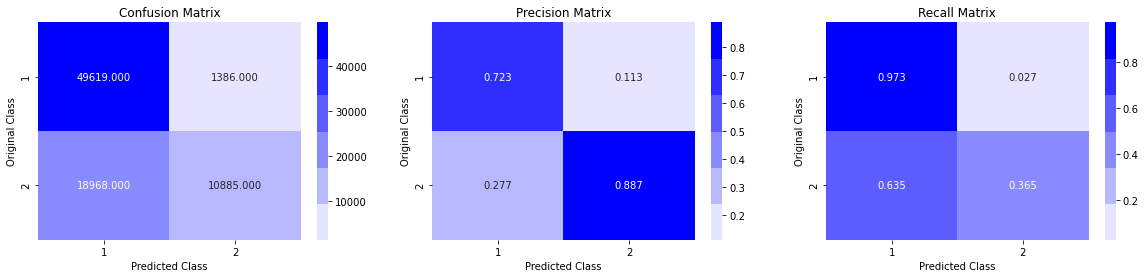

In [7]:
#best_alpha = 0.01
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=7)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = np.argmax(predict_y, axis=1)

plot_confusion_matrix(y_test, predict_y)

For values of alpha =  1e-06  Log-loss:  0.6585300338401181
For values of alpha =  1e-05  Log-loss:  0.4891445299308547
For values of alpha =  0.0001  Log-loss:  0.49728857491059286
For values of alpha =  0.001  Log-loss:  0.49070651821646033
For values of alpha =  0.01  Log-loss:  0.4892304655058358
For values of alpha =  0.1  Log-loss:  0.490235688676665



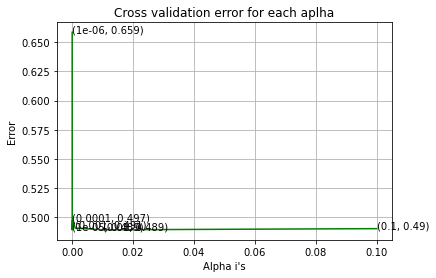

In [8]:
# LINEAR SVM WITH HYPERPARAMETER TUNING

alpha = [10 ** x for x in range(-6, 0)]

log_error_array = []

for i in tqdm_notebook(alpha):
    
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=7)
    clf.fit(X_train, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, ' Log-loss: ', log_loss(y_test, predict_y,  labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g')

for i, text in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i], np.round(text,3)), (alpha[i], log_error_array[i]))

plt.grid()
plt.title('Cross validation error for each aplha')
plt.xlabel("Alpha i's")
plt.ylabel('Error')
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4483026527950345
For values of best alpha =  1e-05 The test log loss is: 0.4891445299308547


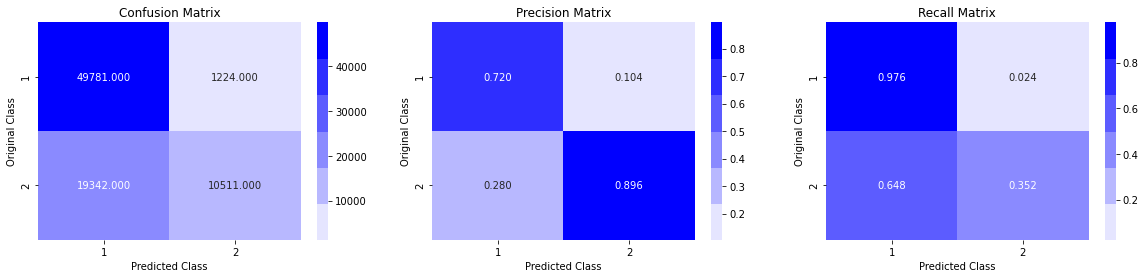

In [9]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=7)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = np.argmax(predict_y, axis=1)

plot_confusion_matrix(y_test, predict_y)

[0]	train-logloss:0.685049	valid-logloss:0.685284
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.617393	valid-logloss:0.620556
[20]	train-logloss:0.567452	valid-logloss:0.573495
[30]	train-logloss:0.530042	valid-logloss:0.538723
[40]	train-logloss:0.501561	valid-logloss:0.512324
[50]	train-logloss:0.479805	valid-logloss:0.492363
[60]	train-logloss:0.462535	valid-logloss:0.476529
[70]	train-logloss:0.448476	valid-logloss:0.463696
[80]	train-logloss:0.437052	valid-logloss:0.453373
[90]	train-logloss:0.42773	valid-logloss:0.445048
[100]	train-logloss:0.420219	valid-logloss:0.43832
[110]	train-logloss:0.413742	valid-logloss:0.432611
[120]	train-logloss:0.408445	valid-logloss:0.427947
[130]	train-logloss:0.404	valid-logloss:0.423984
[140]	train-logloss:0.399971	valid-logloss:0.420388
[150]	train-logloss:0.396643	valid-logloss:0.417472
[160]	train-logloss:0.393738	vali

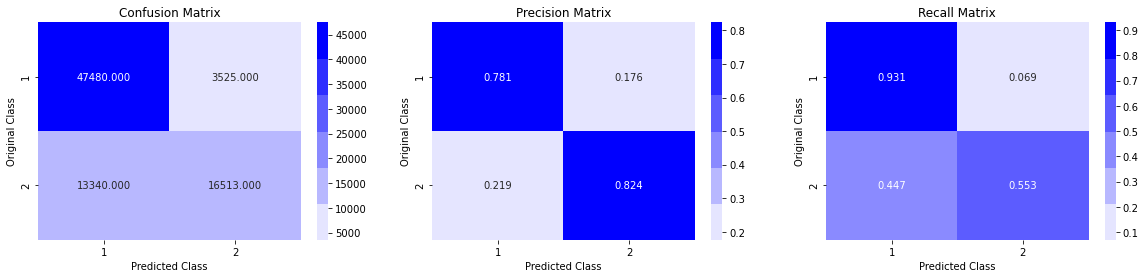

In [10]:
# GBDT

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval = 10)
xgdmat = xgb.DMatrix(X_train, y_train)
predict_y = bst.predict(d_test)

print('Test Log loss', log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
plot_confusion_matrix(y_test, predicted_y)